In [22]:
from datascience import Table
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import copy
import mpl_scatter_density
import numpy as np
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import seaborn as sns; sns.set()
import geohash as gh
from haversine import haversine
%matplotlib inline

**Data Cleaning**

1. Drop passenger count = {0,7,8,9}
2. Drop trips outside nyc
3. Drop trips exceeding one day
4. Drop trips with distance = 0 and trip duration greater than one minute
5. Drop extreme duration trips

In [116]:
data = pd.read_csv('train.csv')
data.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [117]:
data['trip_duration_hour'] = data['trip_duration'] / (60*60)

In [118]:
# conver datatime cols to datetime object
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [120]:
# drop passenger count outliers
pass_outlier = data[(data['passenger_count'] == 9) |
                    (data['passenger_count'] == 7) |
                    (data['passenger_count'] == 8) |
                    (data['passenger_count'] == 0) ]
data = data.drop(index = pass_outlier.index)

In [121]:
# drop trips exceeding one day
duration_outlier = data[data['trip_duration']>= (60*60*24)]
data = data.drop(index = duration_outlier.index)

In [122]:
# trips within new york
# bbox = min latitude , max Latitude , min Longitude , max longitude 
bbox = [40.4773979187012,45.0158615112305,-79.7625122070312,-71.8527069091797]
within_nyc = (data['pickup_longitude'].between(bbox[2], bbox[3], inclusive=True) & data['pickup_latitude'].between(bbox[0], bbox[1], inclusive=True))
within_nyc_drop = (data['dropoff_longitude'].between(bbox[2], bbox[3], inclusive=True) & data['dropoff_latitude'].between(bbox[0], bbox[1], inclusive=True))

In [123]:
# drop trips outside of new york city
location_outlier = data[~(within_nyc & within_nyc_drop)]
data = data.drop(index = location_outlier.index)

In [124]:
data['distance'] = data.apply(lambda x: haversine((x.pickup_latitude, x.pickup_longitude), 
                                                (x.dropoff_latitude, x.dropoff_longitude)), axis=1)

In [125]:
# remove data with distance = 0  and duration > one minute
data = data[~((data['distance']==0) & (data['trip_duration'] > 60))]

In [126]:
((data['trip_duration'] <= 60*60*24)  & (data['trip_duration'] >= 60)).all()

False

In [127]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hour,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,1.188590


**Look at trips that took more than half a day**

In [128]:
half_day = data[((data['trip_duration'] <= 60*60*24) & (data['trip_duration'] >= 60*60*12))]

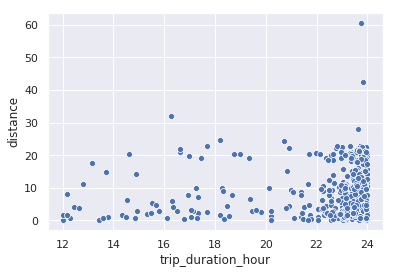

In [129]:
ax = sns.scatterplot(x="trip_duration_hour", y="distance", data=half_day)

In [130]:
# remove data that took more than half a day
data = data.drop(index = half_day.index)

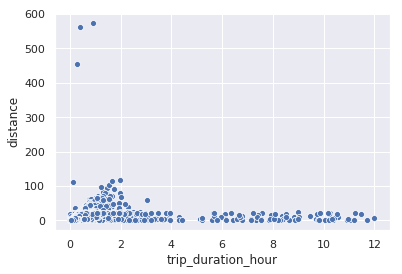

In [132]:
ax = sns.scatterplot(x="trip_duration_hour", y="distance", data=data)

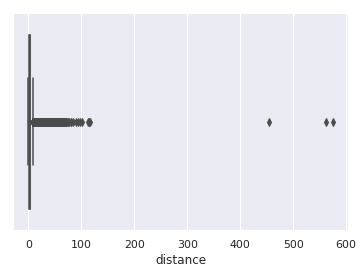

In [133]:
sns.boxplot(data.distance)

In [134]:
dist_outlier = data[data['distance']>400]
dist_outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hour,distance
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,N,1405,0.390278,562.235965
1013474,id3626673,1,2016-05-05 18:02:50,2016-05-05 18:18:23,1,-73.978912,40.756763,-79.338699,41.427902,N,933,0.259167,455.241833
1100676,id2644780,1,2016-05-03 16:24:07,2016-05-03 17:18:34,2,-73.991325,40.750023,-79.518616,43.921028,N,3267,0.907500,574.876237


In [135]:
import folium
# Make an empty map
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

color= [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange'
]
# I can add marker one by one on the map
for i in range(0,len(dist_outlier)):
    folium.Marker([dist_outlier.iloc[i]['pickup_latitude'], dist_outlier.iloc[i]['pickup_longitude']], popup='pickup', icon=folium.Icon(color=color[i])).add_to(m)
    folium.Marker([dist_outlier.iloc[i]['dropoff_latitude'], dist_outlier.iloc[i]['dropoff_longitude']], popup='dropoff', icon=folium.Icon(color=color[i])).add_to(m)

m

**These three trip records are clearly incosistent because the time it takes to go from new york to toronto or penssilvinya takes at least 7 hours **

In [136]:
# drop distance outliers
data = data.drop(index = dist_outlier.index)

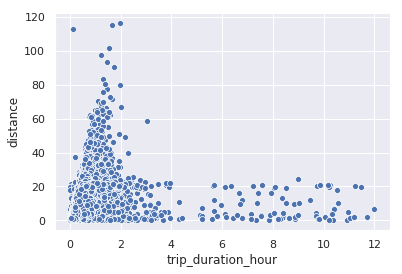

In [137]:
ax = sns.scatterplot(x="trip_duration_hour", y="distance", data=data)

In [169]:
duration_outlier = data[data.trip_duration_hour >= 8]
duration_outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hour,distance
29062,id0025763,2,2016-04-24 13:38:15,2016-04-25,2,-73.782188,40.644619,-73.781830,40.644760,N,37305,10.362500,0.034082
31355,id0309009,2,2016-04-26 12:18:22,2016-04-27,1,-73.978333,40.752384,-73.964569,40.767311,N,42098,11.693889,2.024533
73270,id1430543,2,2016-05-04 13:56:08,2016-05-05,5,-73.994942,40.739845,-73.978775,40.752434,N,36232,10.064444,1.953000
126626,id1078224,2,2016-06-14 13:26:12,2016-06-15,6,-73.862877,40.768913,-73.980919,40.755909,N,38028,10.563333,10.046316
206542,id3260214,2,2016-04-09 12:00:23,2016-04-10,1,-73.934792,40.593227,-73.932243,40.651096,N,43177,11.993611,6.438336
210574,id3416180,2,2016-01-12 15:38:58,2016-01-13,1,-73.895729,40.725296,-73.782982,40.643959,N,30062,8.350556,13.121715
332296,id2977530,2,2016-03-25 12:30:44,2016-03-26,1,-73.789383,40.643120,-73.957748,40.765369,N,41356,11.487778,19.652222
400826,id1523012,2,2016-06-09 15:58:23,2016-06-10,2,-73.799568,40.645512,-74.013779,40.707382,N,28897,8.026944,19.330192
528643,id3253229,2,2016-01-29 14:33:06,2016-01-30,1,-73.789345,40.646671,-73.922340,40.689613,N,34014,9.448333,12.191025
647539,id2456509,2,2016-02-19 14:18:04,2016-02-20,6,-73.967041,40.793785,-73.983894,40.755131,N,34916,9.698889,4.526399


All of these records are missing their dropoff time , so they are incosistent

In [171]:
# drop duration outliers
data = data.drop(index = duration_outlier.index)

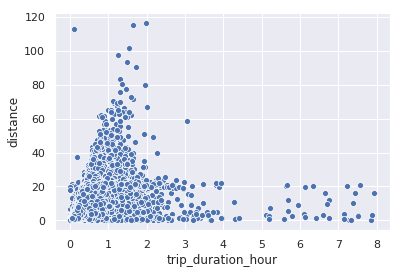

In [172]:
ax = sns.scatterplot(x="trip_duration_hour", y="distance", data=data)

In [173]:
duration_outlier = data[data.trip_duration_hour >= 7]
duration_outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hour,distance
204445,id2005896,1,2016-05-27 11:56:31,2016-05-27 19:13:30,1,-73.987358,40.760464,-73.986656,40.760403,N,26219,7.283056,0.059506
213406,id0579036,2,2016-02-04 16:26:23,2016-02-05 00:00:00,1,-73.781578,40.644821,-73.982460,40.756050,N,27217,7.560278,20.970066
248905,id0378217,2,2016-04-30 16:34:38,2016-05-01 00:00:00,1,-73.782318,40.644741,-73.944893,40.722439,N,26722,7.422778,16.203929
425755,id3921936,2,2016-02-13 16:40:04,2016-02-14 00:00:00,1,-73.938309,40.803127,-73.940796,40.805515,N,26396,7.332222,0.338131
499910,id2597011,2,2016-01-07 16:09:19,2016-01-08 00:00:00,5,-73.990364,40.756107,-73.993401,40.759644,N,28241,7.844722,0.469070
544098,id2341291,2,2016-02-18 16:29:13,2016-02-19 00:00:00,1,-73.994492,40.733986,-73.975647,40.759571,N,27047,7.513056,3.257893
590858,id0392626,2,2016-03-07 16:51:27,2016-03-08 00:00:00,2,-73.887794,40.768520,-73.930313,40.754604,N,25713,7.142500,3.901059
755875,id0651976,2,2016-03-29 16:03:45,2016-03-30 00:00:00,1,-73.804810,40.682446,-73.973373,40.754478,N,28575,7.937500,16.308567
803459,id1648636,2,2016-04-19 16:37:03,2016-04-20 00:00:00,2,-73.975708,40.751041,-73.982712,40.660652,N,26577,7.382500,10.068164
838811,id1051745,2,2016-04-15 16:28:56,2016-04-16 00:00:00,5,-73.959129,40.775108,-73.980614,40.789280,N,27064,7.517778,2.399032


In [174]:
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black',
    'yellow',
    'cyan',
    'lightcyan',
    'darkcyan',
    'mauve',
    'lightmauve',
    'darkmauve',
    'white',
    'darkyellow',
    'lightyellow',
    'pink'
]
# I can add marker one by one on the map
for i in range(0,len(duration_outlier)):
    folium.Marker([duration_outlier.iloc[i]['pickup_latitude'], duration_outlier.iloc[i]['pickup_longitude']], popup='pickup', icon=folium.Icon(color=colors[i])).add_to(m)
    folium.Marker([duration_outlier.iloc[i]['dropoff_latitude'], duration_outlier.iloc[i]['dropoff_longitude']], popup='dropoff', icon=folium.Icon(color=colors[i])).add_to(m)

m

The values of the trip duration are clearly incosistent with the pickup and dropoff locations of the trip

In [175]:
# drop duration outliers
data = data.drop(index = duration_outlier.index)

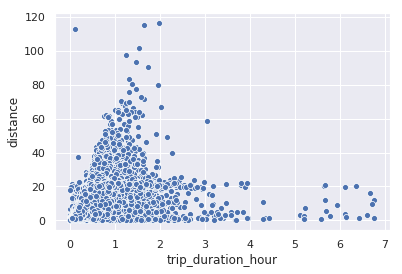

In [176]:
ax = sns.scatterplot(x="trip_duration_hour", y="distance", data=data)

In [199]:
# extreme duration & very short distance
duration_outlier = data[((data.trip_duration_hour >= 5) & (data.distance <= 20))]
duration_outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hour,distance
127198,id1859777,2,2016-02-29 18:18:50,2016-03-01,1,-73.993637,40.752121,-73.967827,40.798859,N,20470,5.686111,5.633141
173931,id2959094,2,2016-03-04 18:52:41,2016-03-05,1,-73.981911,40.778702,-73.957123,40.801800,N,18439,5.121944,3.309283
271725,id3829413,2,2016-05-26 17:52:49,2016-05-27,5,-73.792809,40.658184,-73.978333,40.766392,N,22031,6.119722,19.730343
435302,id3681830,2,2016-05-03 18:47:57,2016-05-04,1,-73.873062,40.774101,-73.889130,40.751335,N,18723,5.200833,2.870473
624250,id3259944,2,2016-04-09 18:19:11,2016-04-10,5,-73.776886,40.645142,-73.704750,40.738361,N,20449,5.680278,12.018083
704210,id3385534,2,2016-05-28 17:14:15,2016-05-29,5,-73.776825,40.645161,-73.870338,40.728161,N,24345,6.762500,12.138741
736882,id3854627,2,2016-04-12 17:53:08,2016-04-13,1,-73.990356,40.759151,-73.999237,40.723244,N,22012,6.114444,4.062258
794685,id0084092,2,2016-05-29 17:23:58,2016-05-30,2,-73.962128,40.779316,-73.988930,40.756184,N,23762,6.600556,3.422116
844853,id0605279,2,2016-01-31 18:03:09,2016-02-01,2,-73.781998,40.644691,-73.824081,40.718201,N,21411,5.947500,8.910958
900579,id2602418,2,2016-02-11 18:12:52,2016-02-12,1,-73.986732,40.733849,-74.004402,40.751099,N,20828,5.785556,2.427998


In [200]:
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

for i in range(0,len(duration_outlier)):
    folium.Marker([duration_outlier.iloc[i]['pickup_latitude'], duration_outlier.iloc[i]['pickup_longitude']], popup='pickup', icon=folium.Icon(color=colors[i])).add_to(m)
    folium.Marker([duration_outlier.iloc[i]['dropoff_latitude'], duration_outlier.iloc[i]['dropoff_longitude']], popup='dropoff', icon=folium.Icon(color=colors[i])).add_to(m)

m

In [201]:
data = data.drop(index = duration_outlier.index)

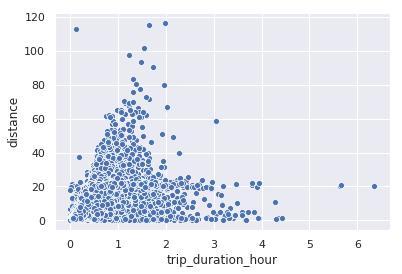

In [202]:
ax = sns.scatterplot(x="trip_duration_hour", y="distance", data=data)

In [203]:
data.shape[0]

1452259

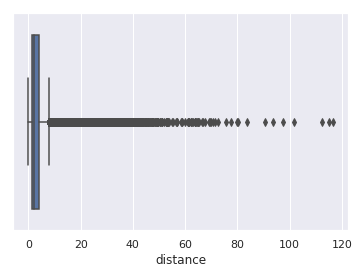

In [204]:
sns.boxplot(data.distance)

**Speed**

Speed limits in nyc are 40km/h & 104 km/h on highways

In [209]:
data['speed'] = data['distance'] / (data['trip_duration']/3600)

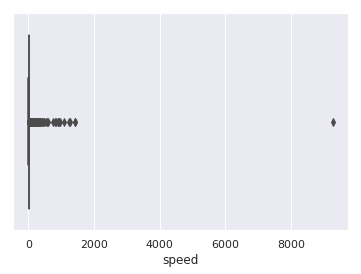

In [210]:
sns.boxplot(data.speed)

In [216]:
# remove trips exceeding speed limit
data = data.drop(data[data.speed >= 104].index)

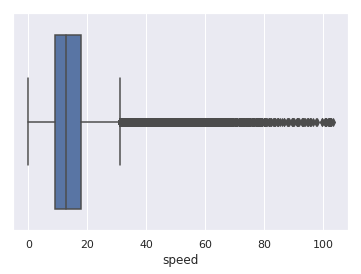

In [218]:
sns.boxplot(data.speed)

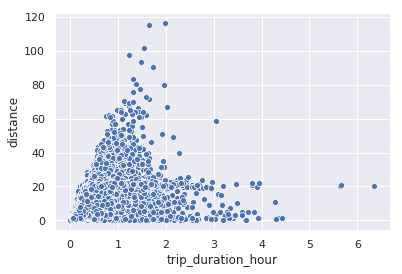

In [223]:
ax = sns.scatterplot(x="trip_duration_hour", y="distance", data=data)

In [225]:
data.to_csv('data_cleaned.csv')

**Run Consistency Checks**

In [31]:
# pickup time < dropoff time
(data['pickup_datetime'] < data['dropoff_datetime']).all()

True

In [33]:
max_capacity = 5 + 1
(data['passenger_count'] <= max_capacity).all()

True

In [34]:
(data['passenger_count'] > 0 ).all()


True

In [35]:
data['pickup_latitude'].between(bbox[0], bbox[1], inclusive=True).all()

True

In [36]:
data['dropoff_latitude'].between(bbox[0], bbox[1], inclusive=True).all()


True

In [37]:
data['pickup_longitude'].between(bbox[2], bbox[3], inclusive=True).all()

True

In [39]:
data['dropoff_longitude'].between(bbox[2], bbox[3], inclusive=True).all()

True

In [40]:
(data['trip_duration'] == (data['dropoff_datetime'] - data['pickup_datetime']).dt.seconds).all()

True

In [41]:
within_nyc = (data['pickup_longitude'].between(bbox[2], bbox[3], inclusive=True) & data['pickup_latitude'].between(bbox[0], bbox[1], inclusive=True))
within_nyc.all()

True

In [42]:
within_nyc_drop = (data['dropoff_longitude'].between(bbox[2], bbox[3], inclusive=True) & data['dropoff_latitude'].between(bbox[0], bbox[1], inclusive=True))
within_nyc_drop.all()

True